## README
In this file, I worked on face detection with PCA and a custom method for sliding window face detection. Then, I compared the it to the Viola-Jones face detector and discussed the pros and cons of each.

Note the data directory is not uploaded to Github due to its large size. Feel free to modify my directory global variable to work on your dataset.

### Dev Env (Python 3.10.5)

numpy==1.26.1

opencv-python==4.9.0.80

matplotlib==3.8.2

scikit-learn==1.4.1.post1

pickleshare==0.7.5

### Imports & Setup
Image directory and image file name can be setup here

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

%matplotlib inline

# Relative dir or absolute dir
PART1_DIR = "part1/"
PART2_IMG_PATH = "part2/Person.png"
CIFAR10_DIR = 'cifar-10-batches-py/'

### Util Functions


In [7]:
def show_images(images, cmap=None):
    """
    Display multiple imgs with a title.
    """
    n_images = len(images)

    # Create a subplot with n_images columns
    fig, axes = plt.subplots(n_images, 1, figsize=(5*n_images, 10))

    # Make sure still works with just one img in the arr
    if n_images == 1:
        axes = [axes]

    for i, img in enumerate(images):
        if cmap:
            axes[i].imshow(img, cmap=cmap)
        else:
            axes[i].imshow(img)
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

def load_and_convert_images_to_grayscale(dir):
    """
    Loads all images from the specified directory, converts them to grayscale, and returns a list of the grayscale images.
    """
    grayscale_images = []

    # Loop through each file
    for filename in os.listdir(dir):
        # Get the full file path
        file_path = os.path.join(dir, filename)
        
        # Check if the file is an image.
        if file_path.lower().endswith(('.jpg')):
            img = cv2.imread(file_path)
            
            # Convert the image to grayscale
            grayscale_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            grayscale_images.append(grayscale_img)

    return grayscale_images

## P1: Face Detection 

### 1.1: Load all images

In [23]:
p2_images = load_and_convert_images_to_grayscale(PART1_DIR)

### 1.2 Implement the Snapshot method for PCA

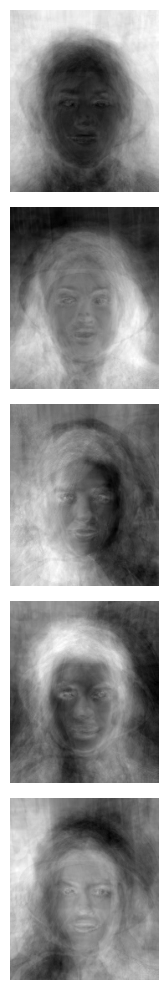

In [24]:
# I will assume all the imgs in the training set are pre-processed with same shape
IMG_SHAPE = p2_images[0].shape
FACE_IMG_NUMBER = 5

def pca(images):
    # Tricks from stack overflow to improve the quality of the eig faces by using equalizeHist as pre-processing
    # From https://stackoverflow.com/questions/19114420/how-to-increase-accuracy-of-eigenface-algorithm
    # But it do not seems to do much so I comment it out
    #eq_images = [cv2.equalizeHist(img) for img in images]
    
    # matrix D (Note we have N images so N x img_h x img_w)
    D = np.array([img.flatten() for img in images]).T
    
    # Calculate the mean face (average image), used for sliding window
    mean_face = np.mean(D, axis=1)
    D = D - mean_face[:, np.newaxis]
    
    # We can left multiply the original eig equation by Dt to reduce matrix size
    # Compute Transpose(D) * D
    DtD = np.dot(D.T, D)
    
    # Find the eige values and eig vectors of Transpose(D) * D
    eigenvalues, eigenvectors = np.linalg.eig(DtD)
    
    # Compute the eigenvectors
    eigenfaces = np.dot(D, eigenvectors)
    
    # Sort the eig values,eig vectors, and eig faces in descending order
    idx = eigenvalues.argsort()[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    eigenfaces = eigenfaces[:, idx]
    
    return eigenfaces, eigenvalues, mean_face

eigenfaces, _, mean_face = pca(p2_images)
face_images = []
for i in range(FACE_IMG_NUMBER):
    face_images.append(eigenfaces[:, i].reshape(IMG_SHAPE))

show_images(face_images, cmap='gray')

## 1.3: Sliding Window Method
## 1.4: Label the detected images with bound boxes

In [29]:
def sliding_window_face_detection(color_image, eigenfaces, mean_face, window_size, step_size, threshold):
    detected_faces = []
    image = cv2.cvtColor(color_image, cv2.COLOR_RGB2GRAY)
    img_height, img_width = image.shape[:2]

    mean_face = mean_face.flatten()
    dist = []  # For my debugging needs
    # Basically the window size is still the same size as the training set.
    # But the step size is what we can configure
    for y in range(0, img_height - window_size[1], step_size):
        for x in range(0, img_width - window_size[0], step_size):
            window = image[y:y + window_size[1], x:x + window_size[0]]
            window = cv2.resize(window, window_size)
            window = cv2.equalizeHist(window)
            window_flat = window.flatten()

            # Subtracting the mean_face
            window_centered = window_flat - mean_face

            # Project the centered window onto the PCA eigenspace and then calc Euclidean distance
            window_projected = np.dot(eigenfaces.T, window_centered)
            distance = np.linalg.norm(window_projected)

            if distance < threshold:
                detected_faces.append((x, y, x + window_size[0], y + window_size[1]))
                dist.append(distance)

    dist.sort()
    print(f"DEBUG: top 10 dist: {dist[:10]}")
    # Draw bounding boxes on the color image
    for (startX, startY, endX, endY) in detected_faces:
        cv2.rectangle(color_image, (startX, startY), (endX, endY), (0, 255, 0), thickness=8)

    return detected_faces, color_image

## 1.5: Set Threathold
Basically we have two variables here we can configure. 

### STEP SIZE
The window step size determines how much the window will move left or down. The smaller the step size, the more detected faces we can find and we will also get a gain in the distance for the best matching faces. This comes with the cost of performance. So I found 30 to be a good spots with good number of points selected and run time.

### THREATHOLD
I used a dist list that holds all the distances just to check for the first time where the values generally sits. I found they sits around 230000000. It seems large and it may give illusion that the points are all over the place. Actually, even if we set it to 210000000 there will be barely any points and if we set it to 240000000 almost all the points are included. So this tells us the THREATHOLD is still sensitive and valid to toggle around around the mean.

I have selected the THREATHOLD value of 217000000 as it detect most if not all the faces and also under this THREATHOLD the noise is also low.

DEBUG: top 10 dist: [208793432.37933758, 210070449.65232533, 210238331.3665362, 210997895.96652764, 211818929.2218835, 211860262.4586052, 212343948.3046981, 213877713.11354107, 214522176.25936463, 215238794.17704797]


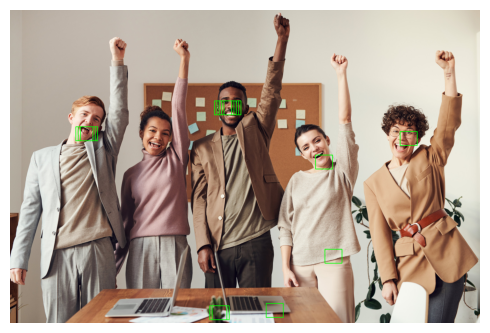

In [30]:
THREATHOLD = 217000000
STEP_SIZE = 30

p2_img = cv2.imread(PART2_IMG_PATH)
p2_img = cv2.cvtColor(p2_img, cv2.COLOR_BGR2RGB)

detected_faces, img_after = sliding_window_face_detection(p2_img, eigenfaces, mean_face, IMG_SHAPE, STEP_SIZE, THREATHOLD)
show_images([img_after])

## 1.6: Viola-Jones Face Detector

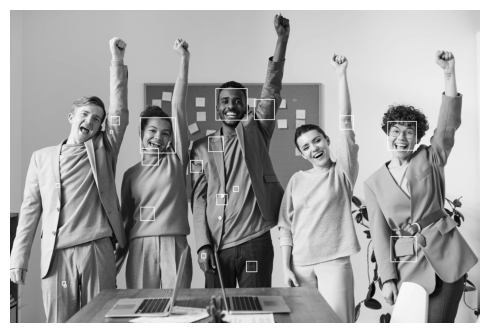

In [28]:
p2_img_viola_jones = cv2.imread(PART2_IMG_PATH)
p2_img_viola_jones = cv2.cvtColor(p2_img_viola_jones, cv2.COLOR_BGR2GRAY)

face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
faces = face_cascade.detectMultiScale(p2_img_viola_jones, scaleFactor=1.1)

# Draw rectangles around each face
for (x, y, w, h) in faces:
    cv2.rectangle(p2_img_viola_jones, (x, y), (x+w, y+h), (255, 0, 0), thickness=8)

show_images([p2_img_viola_jones], cmap="gray")

## 1.6: Compare
I am actually supprised that the sliding window solution with training set is able to detect 4 faces compared to 3 of the Viloa-Jones here. In addition the sliding windows seems to be able to find less noise as well.
I belive This is largly because the sliding window solution is really fine tuned.

## 1.7: Evaluate

### Sliding Window:
Positive points: 4

Negative points: 3

Positive rate = 57%

Please note that for multiple windows overlapping with each others closely, I will count them as one. Because in more complexed implementations they will be post-filteterd into one anyway. (Perhaps with the non-maxium compression we have learned?)

### Viloa-Jones:
Positive points: 3

negative points: 14

positive rate = 17%


## 1.8
Viola-Jones detector detection speed is much faster than PCA since it utilizes Integral images and Attentional cascade. This means that Viola-Jones detector is more suitable for real-time detection needs such as real-time security face detection at airport

In [32]:
import time
TEST_RUN_NUMBER = 5

# Load the images
color_image = cv2.imread(PART2_IMG_PATH)
gray_image = cv2.cvtColor(color_image, cv2.COLOR_BGR2GRAY)
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

viola_jones_times = []
sliding_window_times = []

for _ in range(TEST_RUN_NUMBER):
    # Viola-Jones
    start_time = time.time()
    faces = face_cascade.detectMultiScale(gray_image, scaleFactor=1.1)
    viola_jones_times.append(time.time() - start_time)
    
    # Sliding Window
    start_time = time.time()
    sliding_window_face_detection(color_image.copy(), eigenfaces, mean_face, IMG_SHAPE, STEP_SIZE, THREATHOLD)
    sliding_window_times.append(time.time() - start_time)

# Calculate and print average runtimes
avg_viola_jones_time = np.mean(viola_jones_times)
avg_sliding_window_time = np.mean(sliding_window_times)

print(f"INFO: Average Viola-Jones Runtime: {avg_viola_jones_time:.4f} seconds")
print(f"INFO: Average Sliding Window Runtime: {avg_sliding_window_time:.4f} seconds")


DEBUG: top 10 dist: [209147092.19306397, 209650496.71608657, 210454450.3143689, 210802871.74401304, 212002201.81741717, 212975966.33357936, 213717182.52404258, 214125632.8784901, 214464791.31144065, 214890430.61298725]
DEBUG: top 10 dist: [209147092.19306397, 209650496.71608657, 210454450.3143689, 210802871.74401304, 212002201.81741717, 212975966.33357936, 213717182.52404258, 214125632.8784901, 214464791.31144065, 214890430.61298725]
DEBUG: top 10 dist: [209147092.19306397, 209650496.71608657, 210454450.3143689, 210802871.74401304, 212002201.81741717, 212975966.33357936, 213717182.52404258, 214125632.8784901, 214464791.31144065, 214890430.61298725]
DEBUG: top 10 dist: [209147092.19306397, 209650496.71608657, 210454450.3143689, 210802871.74401304, 212002201.81741717, 212975966.33357936, 213717182.52404258, 214125632.8784901, 214464791.31144065, 214890430.61298725]
DEBUG: top 10 dist: [209147092.19306397, 209650496.71608657, 210454450.3143689, 210802871.74401304, 212002201.81741717, 2129

## 1.9 Performance of Viola-Jones and steps to achieve the final result

The performance of both Viola-Jones and Sliding window is evaluate above and ran for 5 times each to get the aerage run time. As we can see the Viola-Jones detection is much faster with average runtime of 1.3675 seconds compared to that of 15.3370 seconds. (I can technically change the window step size for the sliding window method to make the sliding window faster but at that point the aquacy will be far less than Viola-Jones).

The Viola-Jones face detection work by firstly computing the Integral Image,then, it uses Haar-like features to identify facial characteristics, selecting the most effective ones with the Adaboost algorithm. These features are applied using a cascade of classifiers to quickly discards non-facial regions, significantly reducing computation time. Finally, the algorithm scans the image with a sliding window approach at multiple scales to detect faces of various sizes. 